In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

In [2]:
image_path = './images/image.png'
img_bgr_origin = cv2.imread(image_path)
img_bgr = img_bgr_origin.copy()
img_show = img_bgr_origin.copy()
img_bgr_addWeighted = img_bgr_origin.copy()

detector_hog = dlib.get_frontal_face_detector()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

바운딩박스

rectangles[[(266, 93) (489, 316)]]


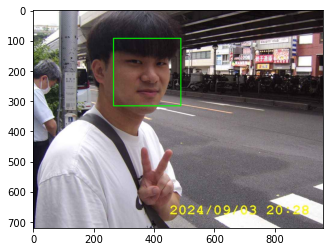

In [3]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [4]:
model_path = './models/shape_predictor_68_face_landmarks.dat'

landmark_predictor = dlib.shape_predictor(model_path)

In [5]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


랜드마크

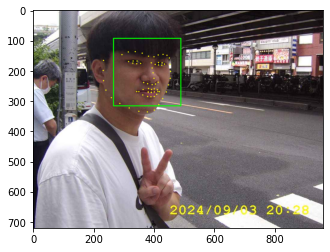

In [6]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

스티커 위치 : 코(30번)

In [7]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])
    x = landmark[28][0]
    y = landmark[30][1]
    w = h = dlib_rect.width()
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(400, 225)
(x,y) : (394,225)
(w,h) : (224,224)


(224, 224, 3)


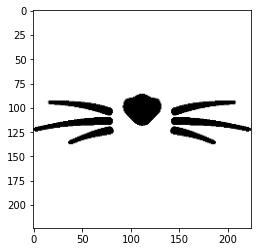

In [8]:
sticker_path = './images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))

print (img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

30번 랜드마크 정중앙에 스티커 위치

In [9]:
refined_x = x - w // 2
refined_y = y - h // 2

if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
    
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

고양이 스티커 모양이 검정색이므로 img_sticker==255(흰색)일때 원본, 그 외 스티커

In [10]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

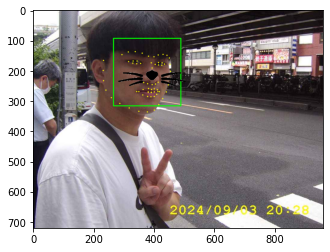

In [11]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

원본 이미지에 적용

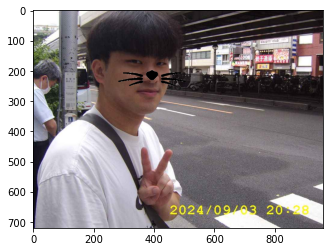

In [12]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

addWeighted를 사용한 이미지
addWeighted(첫번째 이미지, 가중치, 두번째 이미지, 가중치, 감마)

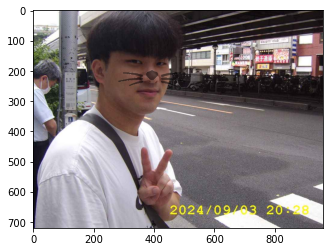

In [13]:
img_bgr_addWeighted = cv2.addWeighted(img_bgr, 0.5, img_bgr_addWeighted, 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr_addWeighted, cv2.COLOR_BGR2RGB))
plt.show()

### 문제점
- 누워서 촬영된 사진 혹은 뒤집어진 사진 등은 침대나 이불 등의 사물에 가려저 얼굴이 재대로 인식하지 못할 수 있다.
- 앱으로 사용하려면 실시간으로 얼굴위치를 찾고 좌표계산을 통해 스티커를 넣어야하기 때문에 역동적인 상황에 대비할 수 있도록 실행속도가 빨라야한다.
- 스티커가 사용자 위치 지정 없이 자동으로 얼굴을 인식하고 위치를 잡기 때문에 정확도가 낮으면 앱을 사용할 수 없다.
- 촬영 거리가 너무 멀면 픽셀 해상도 문제로 얼굴이 재대로 인식되지 않을 수 있고 스티커 이미지가 지나치게 작아져서 뭉게질 수 있다.
- 이미지 밝기가 너무 어둡거나 너무 밝으면 얼굴의 경계선이 불분명해져서 얼굴이 잘 인식되지 않을 수 있다.
- 3차원에서 물체가 3방향으로 회전할 수 있는데 이에 대한 각도 보정이 필요하다.(스티커를 각도에 맞게 회전 혹은 왜곡이 필요하다.)

### 이미지 밝기 보정 후 스티커 적용 범위 탐색

함수 알고리즘

- 이미지 그레이스케일 변환
- 평균 밝기 계산
- 계산된 밝기값으로 컬러 이미지 픽셀값에 곱
    - 평균밝기가 128(기준밝기)이 되도록 곱함 pixelValue = (pixelValue * (128 / 평균밝기)).astype('uint8')
    - 기준밝기(128)은 모델이 가장 성능이 좋은 값으로 변경가능 이번 실습에서는 임의로 픽셀값 중간인 128로 설정(픽셀값 범위 : 0~255)
- 밝기 보정된 컬러 이미지로 바운딩박스 및 랜드마크 계산
- 보정된 이미지로 찾은 위치로 원본이미지에 스티커 추가
- 한계점
    - 밝은 이미지의 경우 명암비가 줄어들기 때문에 오히려 윤곽이 더 사라질 수 있음(모델의 성능에 따라 다를 수 있음)
        - 이를 해결하기 위해 조건문을 통해 평균 명암값이 일정치 이하일 경우에만 적용되도록 실행할 수 있음

In [14]:
img_contrast_correction = img_bgr_origin.copy()
img_contrast_gray = cv2.cvtColor(img_contrast_correction, cv2.COLOR_BGR2GRAY)
img_contrast = np.mean(img_contrast_gray)
print(img_contrast)

117.05755787037037


그냥 상수곱을 진행할 경우 uint8의 범위를 초과한경우 오버플로우가 발생합니다.
np.where를 통해 오버 플로우가 발생하는 경우 최대값을 출력하도록 합니다.

In [15]:
contrast_standard = 128
img_contrast_corrected = np.where((img_contrast_correction * (contrast_standard / img_contrast)) > 255, 255, (img_contrast_correction * (contrast_standard / img_contrast)).astype('uint8'))

rectangles[[(266, 93) (489, 316)]]


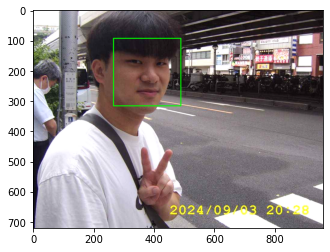

In [16]:
detector_hog = dlib.get_frontal_face_detector()

img_contrast_corrected_rgb = cv2.cvtColor(img_contrast_corrected, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_contrast_corrected_rgb, 1)

print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_contrast_corrected, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_contrast_corrected_rgb = cv2.cvtColor(img_contrast_corrected, cv2.COLOR_BGR2RGB)
plt.imshow(img_contrast_corrected_rgb)
plt.show()

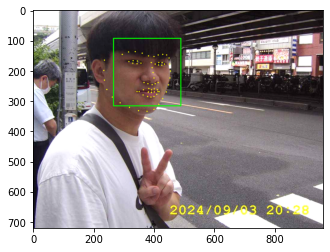

In [17]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_contrast_corrected_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_contrast_corrected, point, 2, (0, 255, 255), -1)

img_contrast_corrected_rgb = cv2.cvtColor(img_contrast_corrected, cv2.COLOR_BGR2RGB)
plt.imshow(img_contrast_corrected_rgb)
plt.show()

In [18]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])
    x = landmark[28][0]
    y = landmark[30][1]
    w = h = dlib_rect.width()
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(400, 224)
(x,y) : (394,224)
(w,h) : (224,224)


In [19]:
sticker_path = './images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))

In [20]:
refined_x = x - w // 2
refined_y = y - h // 2

if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
    
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

In [21]:
img_contrast_addWeighted = img_contrast_correction.copy()

찾은 좌표값을 기반으로 원본 이미지에 스티커 부착

In [22]:
sticker_area = img_contrast_correction[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_contrast_correction[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

addWeighted추가

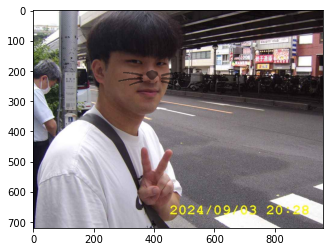

In [23]:
img_contrast_addWeighted = cv2.addWeighted(img_contrast_correction, 0.5, img_contrast_addWeighted, 0.5, 0)
plt.imshow(cv2.cvtColor(img_contrast_addWeighted, cv2.COLOR_BGR2RGB))
plt.show()

위 과정을 함수로 만들면...

In [24]:
def contrast_correct_sticker_img(img_bgr):
    img_contrast_correction = img_bgr.copy()
    img_contrast_gray = cv2.cvtColor(img_contrast_correction, cv2.COLOR_BGR2GRAY)
    img_contrast = np.mean(img_contrast_gray)
    model_path = './models/shape_predictor_68_face_landmarks.dat'

    landmark_predictor = dlib.shape_predictor(model_path)
    
    contrast_standard = 128
    img_contrast_corrected = np.where((img_contrast_correction * (contrast_standard / img_contrast)) > 255, 255, (img_contrast_correction * (contrast_standard / img_contrast)).astype('uint8'))
    
    detector_hog = dlib.get_frontal_face_detector()

    img_contrast_corrected_rgb = cv2.cvtColor(img_contrast_corrected, cv2.COLOR_BGR2RGB)
    dlib_rects = detector_hog(img_contrast_corrected_rgb, 1)

    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img_contrast_corrected, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    list_landmarks = []

    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_contrast_corrected_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_contrast_corrected, point, 2, (0, 255, 255), -1)
    
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        print (landmark[30])
        x = landmark[28][0]
        y = landmark[30][1]
        w = h = dlib_rect.width()
        
    sticker_path = './images/cat-whiskers.png'
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w, h))
    
    refined_x = x - w // 2
    refined_y = y - h // 2

    if refined_x < 0: 
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0
    
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :]
        refined_y = 0
        
    img_contrast_addWeighted = img_contrast_correction.copy()
    
    sticker_area = img_contrast_correction[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_contrast_correction[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)
    
    img_contrast_addWeighted = cv2.addWeighted(img_contrast_correction, 0.5, img_contrast_addWeighted, 0.5, 0)
    return img_contrast_addWeighted

(400, 224)


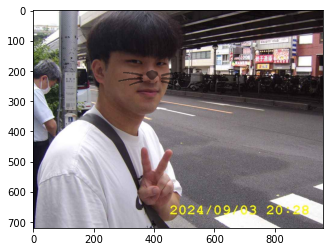

In [25]:
img_def_test = img_bgr_origin.copy()
plt.imshow(cv2.cvtColor(contrast_correct_sticker_img(img_def_test), cv2.COLOR_BGR2RGB))
plt.show()

### 머리 각도에 따른 스티커 회전/왜곡

![screenshot.jpg](./images/screenshot.jpg)

- Yaw(고개 돌림)
    - 얼굴 좌우 윤곽 끝(ex. 0번과 16번) x좌표의 평균(얼굴 좌우 축 중심)과 코끝(33번)의 x좌표를 arcsin을 통해 각도 파악 후 스티커를 각도에 맞게 3d회전 이미지 변환
- Roll(고개 갸우뚱)
    - 두 눈 끝(각 눈의 같은 부위 ex. 36번과 45번) 2점의 x, y좌표를 통해 고개의 roll방향 각도 계산
- Pitch(고개 끄덕)
    - 턱 가장 아래점(8번)과 콧날 아래 끝(30번), 콧날 위끝(27번)의 거리간의 비율을 통해 각도 계산
        - 기준은 경북대학교 석사 논문을 참고했습니다.
        - https://www.riss.kr/search/detail/DetailView.do?p_mat_type=be54d9b8bc7cdb09&control_no=7264f5a649c3e601ffe0bdc3ef48d419&outLink=K
- 한계점
    - 피사체의 헤어스타일 혹은 주변 사물에 따라 얼굴이 가려질 경우 윤곽의 좌표가 바뀌어서 정확한 각도가 계산되지 않을 수 있음
    - 이목구비 위치 및 비율에서 사람간의 편차로 인해 실제 각도와 다른 각도로 적용될 수 있음
    - 특히 Pitch방향으로의 각도 계산을 위해서 보편적인 인간 얼굴 좌표정보가 중요함